## Air Pressure System Failures in Scania Trucks

#### Data downloaded from Kaggle (UCI ML). https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set License is GPL 2

#### Data is also available from UCI Machine Learning Repository and is published under  the GNU General Public License.

### This dataset and challenge was a competition at the 15th Intelligent Data Analysis (IDA 2016) conference.  Challenge is to predict failures and minimize cost function of taking trucks off the road.

#### Cost_1 is 10 for a false positive (cost of unnecessary system inspection) and Cost_2 is 500 for a false negative (cost of a truck missing required service)

### From the original competition description:
     The total cost of a prediction model the sum of "Cost_1" 
     multiplied by the number of Instances with type 1 failure 
     and "Cost_2" with the number of instances with type 2 failure, 
     resulting in a "Total_cost".

     In this case Cost_1 refers to the cost that an unnessecary 
     check needs to be done by an mechanic at an workshop, while 
     Cost_2 refer to the cost of missing a faulty truck, 
     which may cause a breakdown.

     Total_cost = Cost_1*No_Instances + Cost_2*No_Instances

Methodology:
1. Load data and explore data types and null values. Data is provided in 2 files: aps_failure_training_set.csv and aps_failure_test_set.csv.  The test set file is reserved and used as X_Test and Y_Test.  The training set is split for training & validation 80/20 (x_train & x_test).
2. Run a Spearman correlation between all features and the classification.  Drop low correlated features.
3. Check remaining NAN count and get a reduced training set by removing all NaN values from the Training set.
4. Fit a RF classifier to the x_train set. Check performance with the x_test set and report feature importances.
5. Apply a weighted decision threshold to account for the unbalanced penalty for misclassified samples (500 for a false negative, 10 for a false positive).
6. Drop low importance features and fit a model using RandomForestClassifier with RandomizedSearch.
7. Go back to the original Train & Test sets; drop unecessary features and fill NAN's with the mode value for each feature.
8. Fit a RFC model with the same hyperparameters from the RandomizedSearch on the Training dataset x_train, checked on 20% subset x_test, then get final validation cost on the unused Test set.

Results:
1. The final model yields a cost of 9060 on the aps_failure_test_set.csv dataset with 7 False Negatives (cost of 500 each) and 556 False Positives (cost of 10 each).  The set contains 15625 true negatives and 375 true positives (trucks requiring inpection and repair).
2. The FN rate is 1.9% and the FP rate is 3.6%



In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from time import time
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Define plotting functions from py file
exec(open('APS_Failure_Functions.py').read())

Defining Plot_Correlation_w_Class(df, _title):
Defining Plot_Probs_Histogram(y_probs, _title):
Defining Plot_Cost_v_DT(y_test, y_probs, sample_name, Zoom_Y_lim): 
Defining Plot_Conf_Matrix(cm, Title):


In [4]:
# Load files
df_train = pd.read_csv('aps_failure_training_set.csv')
df_test = pd.read_csv('aps_failure_test_set.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 20.9+ MB


#### The dataframes contain object dtypes.  These will be converted to numeric.

In [7]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [8]:
df_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


#### The dataframes inlcude 'na' in place of null values.  Investigate how many columns have 'na' entries & the number per column.

In [9]:
cols = df_train.columns

In [10]:
num_train_na = []
num_test_na = []
for col in cols:
    if 'na' in df_train[col].values:
        num_train_na.append( (df_train[col].values == 'na').sum() )
    if 'na' in df_test[col].values:
        num_test_na.append( (df_test[col].values == 'na').sum() )
print('Number of Train Columns with na is', len(num_train_na),' out of 170 columns excluding Class')
print('Number of Test Columns with na is', len(num_test_na),' out of 170 columns excluding Class')

Number of Train Columns with na is 169  out of 170 columns excluding Class
Number of Test Columns with na is 169  out of 170 columns excluding Class


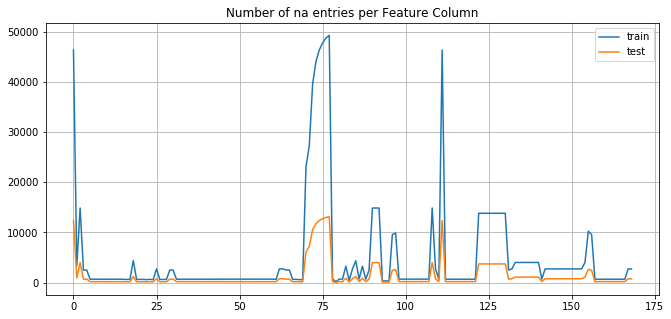

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (11, 5))
plt.plot(num_train_na, label = 'train')
plt.plot(num_test_na, label = 'test')
plt.title('Number of na entries per Feature Column')
plt.grid()
plt.legend()
plt.show()

#### Consider dropping features with more than 10,000 missing entries, after exploring correlation with class and feature importance.  

#### Replace neg / pos class labels with 0 / 1.
#### Then convert dataframe to numeric and drop low correlation features using Spearman correlation.  
#### Then creat a copy Train set and drop all NaNs and look into the feature importance with a preliminary Random Forest fit.  Drop low importance features.

In [12]:
# Replace neg / pos in class with target values 0 / 1
df_train['class'] = df_train['class'].apply(lambda x: 0 if x == 'neg' else 1)
df_train['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [13]:
# Replace neg / pos in class with target values 0 / 1
df_test['class'] = df_test['class'].apply(lambda x: 0 if x == 'neg' else 1)
df_test['class'].value_counts()

0    15625
1      375
Name: class, dtype: int64

In [14]:
# Convert to numeric  df = df.apply(pd.to_numeric)
df_train = df_train.apply(pd.to_numeric, errors='coerce')
df_test = df_test.apply(pd.to_numeric, errors='coerce')

In [15]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [16]:
df_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [17]:
# Save Spearman correlation results to df
df_spearman_corr_train = df_train.corr(method = 'spearman')

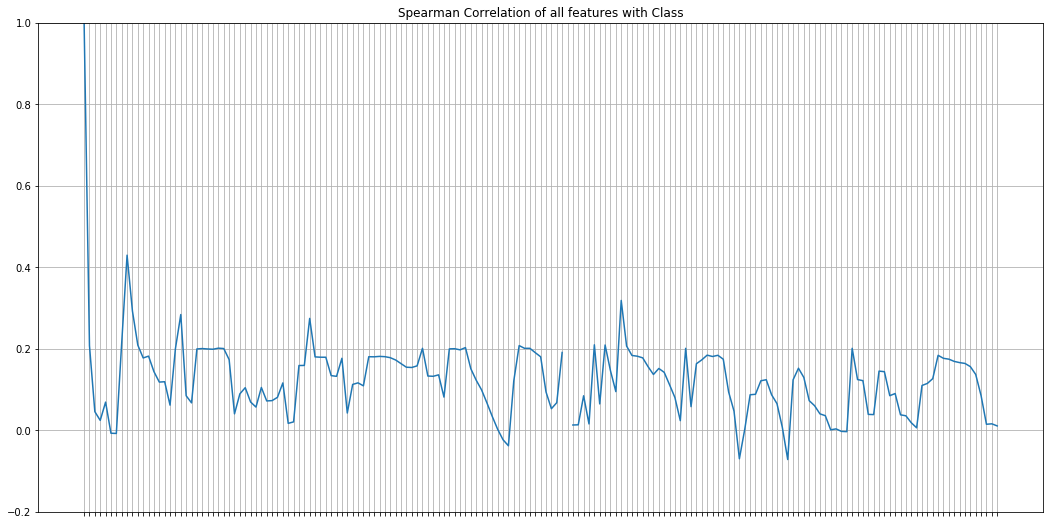

In [18]:
Plot_Correlation_w_Class(df_spearman_corr_train,'Spearman Correlation of all features with Class')

In [19]:
df_spearman_corr_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
class,1.000000,0.207301,0.045629,0.024242,0.069010,-0.007283,-0.007822,0.214204,0.429422,0.292314,...,0.174394,0.168883,0.165938,0.163910,0.156106,0.136871,0.084863,0.014743,0.015789,0.010655
aa_000,0.207301,1.000000,0.086633,0.365147,0.713492,-0.072065,-0.078124,0.071678,0.133163,0.173015,...,0.894772,0.895879,0.889076,0.880313,0.854434,0.795288,0.773779,0.575935,0.012616,-0.010337
ab_000,0.045629,0.086633,1.000000,0.082870,0.097796,-0.072122,-0.074205,0.033460,0.062113,0.077746,...,0.169895,0.156902,0.148846,0.131970,0.111531,0.115303,0.131798,0.052042,0.019606,0.024196
ac_000,0.024242,0.365147,0.082870,1.000000,0.677207,-0.001818,0.001295,0.030443,0.047917,0.033004,...,0.354738,0.345730,0.333464,0.319016,0.318748,0.298394,0.296479,0.220822,0.040210,0.036164
ad_000,0.069010,0.713492,0.097796,0.677207,1.000000,-0.093598,-0.096810,0.044677,0.059494,0.010072,...,0.742391,0.721558,0.704685,0.680271,0.636782,0.596299,0.677618,0.569064,0.015703,-0.009574


In [20]:
# Reduce features by dropping columns where the absolute value of the correlation is less than 0.1
drop_list_train = []
for col in cols:
    if abs( df_spearman_corr_train['class'][col] ) < 0.19:
        drop_list_train.append(col)
        
print('There are ', len(drop_list_train), 'features in the drop list: \n', drop_list_train)

There are  139 features in the drop list: 
 ['ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'aj_000', 'ak_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'cj_000', 'cl_000', 'cm_000', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'co_000', 'cp_000', 'cr_000', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cs_006', 'cs_007', 'cs_008', 'cs_009', 'ct_000', 'cu_000', 'cv_0

#### Drop low correlation features.

In [21]:
Train = df_train.drop(drop_list_train, axis = 1)
Test = df_test.drop(drop_list_train, axis = 1)

In [22]:
# Check how many of the remaining features are missing significant numbers of values.
num_Train_nan = []
num_Test_nan = []
for col in Train.columns:
    if Train[col].isnull().any():
        num_Train_nan.append( Train[col].isnull().sum() )
    if Test[col].isnull().any():
        num_Test_nan.append( Test[col].isnull().sum() )
print('Number of Train Columns with NaN is', len(num_Train_nan),' out of 31 remaining columns excluding Class')
print('Number of Test Columns with NaN is', len(num_Test_nan),' out of 31 remaining excluding Class')

Number of Train Columns with NaN is 30  out of 31 remaining columns excluding Class
Number of Test Columns with NaN is 30  out of 31 remaining excluding Class


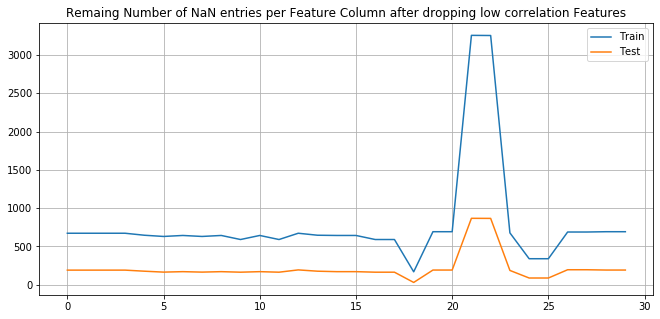

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (11, 5))
plt.plot(num_Train_nan, label = 'Train')
plt.plot(num_Test_nan, label = 'Test')
plt.title('Remaing Number of NaN entries per Feature Column after dropping low correlation Features')
plt.grid()
plt.legend()
plt.show()

#### This set of features has at most approximately 5% NaN's and the majority is around 1%, leaving a large dataset to train on with actual values rather than filled values.
#### Create a copy of the Train set and drop all rows with NaN.  Replot the Spearman correlation on the reduced dataset.  Then run a RFC model and get feature importance.  Use that to drop remainglow importance features.

In [24]:
df_copy = Train.dropna()
print('df with no nulls has a shape of', df_copy.shape)
print('df with no nulls has class count of\n', df_copy['class'].value_counts())

df with no nulls has a shape of (55657, 32)
df with no nulls has class count of
 0    54746
1      911
Name: class, dtype: int64


In [25]:
#Check Spearmon correlation on the reduced dataset 
df_spearman_corr_copy = df_copy.corr(method = 'spearman')

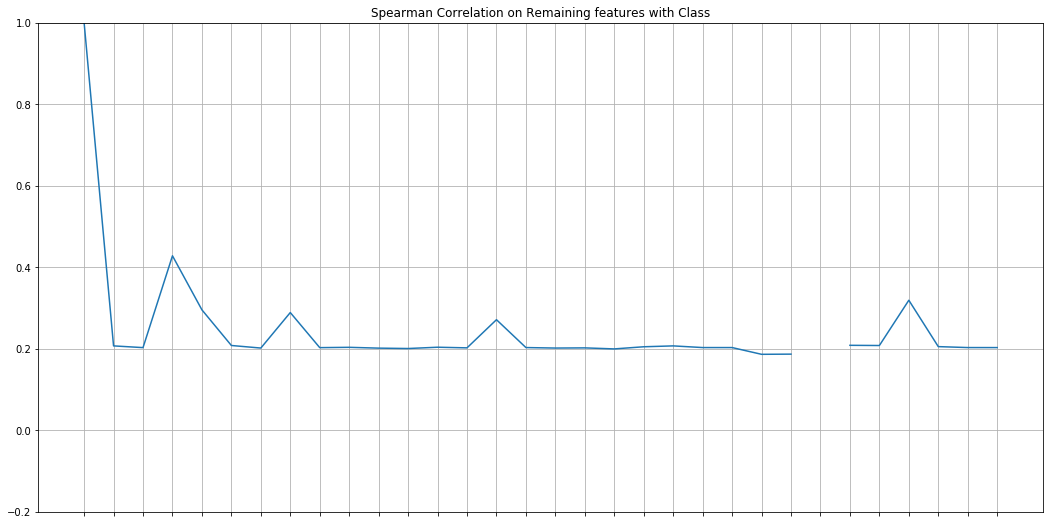

In [26]:
Plot_Correlation_w_Class(df_spearman_corr_copy,'Spearman Correlation on Remaining features with Class')

#### Split the df_copy set into a train & test set and run RF Classifier to get feature importance.

In [27]:
y_copy = df_copy.iloc[:,0]
x_copy = df_copy.iloc[:,1:]

In [28]:
# Preserve the ratio of TP & TN in the train & test sets using 'stratify'
x_train, x_test, y_train, y_test = train_test_split(x_copy, y_copy, stratify = y_copy, test_size = 0.20, random_state = 6)

In [29]:
# Scale Train & Test
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [30]:
y_train.value_counts()

0    43796
1      729
Name: class, dtype: int64

In [31]:
y_test.value_counts()

0    10950
1      182
Name: class, dtype: int64

#### Propose using a decision threshold applied to the probabilities from predict_proba.  The datset is underbalanced and the cost model is highly skewed (500:10) so options vs. a coin toss of 0.5 include:
#### 1. Using the ratio of TP to all samples (182/11132 for the test set w/o nulls) or 0.01634.  i.e guessing a sample true status as negative would be correct 98.4% odf the time.  A good model should have a majority of 0 values from predict_proba (see histogram below).
#### 2. Using the ratio of FP+FN cost for a balanced cost model to the unbalanced cost model and adjust a 0.5 decision threshold.       Which is (10+10)/(10+500) * 0.5 = 0.0196.  (If the FP cost was higher, this value would be subtrated from 1 to yield a DT)
#### Apply the second DT as it is consistent across all datasets and is cost based.  This is compared with a balanced cost model in the cost charts.  The balanced cost model has a minimum near 0.5.  The unbalanced cost model has a minimum near zero and varies by model.

In [32]:
#Fit the first RFC model to get feature importance
first_clf = RandomForestClassifier(class_weight={0:500, 1:10},n_estimators = 140, max_depth = 40, random_state = 6, n_jobs = -1).fit(x_train, y_train)

In [33]:
y_probs = first_clf.predict_proba(x_test)
y_pred = y_probs[:,1] > 0.0196
cm = confusion_matrix(y_test, y_pred)
print('Cost on Validation Subset of the Training set (x_test) is', 10*cm[0][1] + 500*cm[1][0],'\n')
print(cm)

Cost on Validation Subset of the Training set (x_test) is 8820 

[[10418   532]
 [    7   175]]


In [34]:
print('Classification Report on Validation Subset of the Training set (x_test) is\n')
print(classification_report(y_test, y_pred))

Classification Report on Validation Subset of the Training set (x_test) is

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10950
           1       0.25      0.96      0.39       182

    accuracy                           0.95     11132
   macro avg       0.62      0.96      0.68     11132
weighted avg       0.99      0.95      0.97     11132



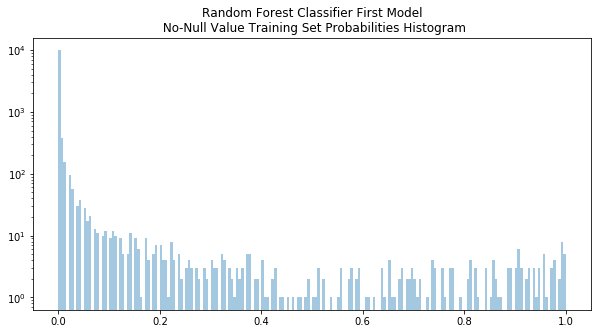

In [35]:
Plot_Probs_Histogram(y_probs, 'Random Forest Classifier First Model\n No-Null Value Training Set Probabilities Histogram')

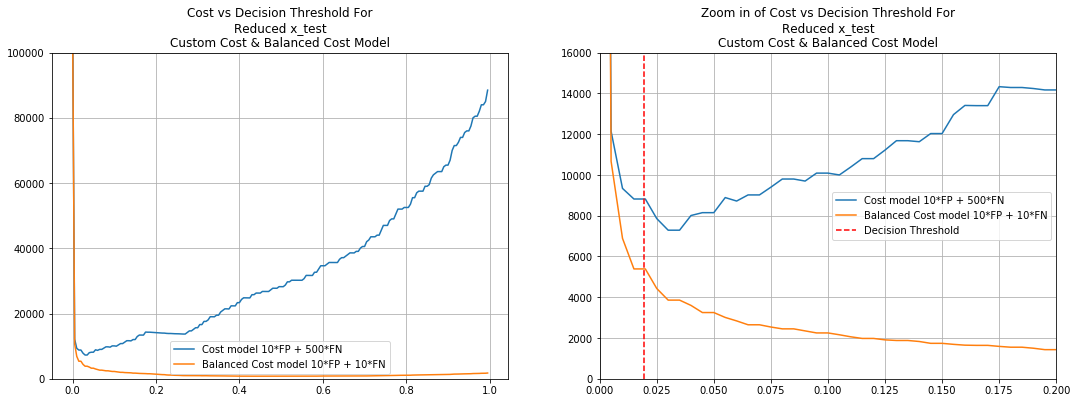

In [36]:
Plot_Cost_v_DT(y_test, y_probs, 'Reduced x_test', 16000)

In [37]:
# Get Feature Importance
Feature_i = first_clf.feature_importances_
Features = pd.DataFrame(Feature_i, index = x_copy.columns, columns = ['F_I'] )

Features.head()

,F_I
aa_000,0.033506
ag_000,0.008255
ag_001,0.046793
ag_002,0.061944
ag_003,0.044873


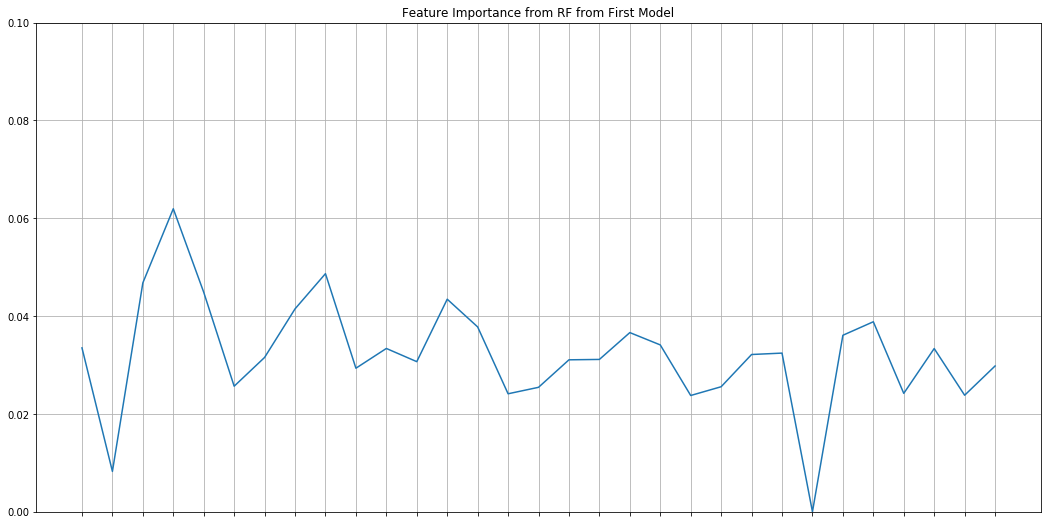

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (18, 9))
plt.plot(Features.F_I)
plt.title('Feature Importance from RF from First Model')
plt.tick_params(labelbottom=[])
plt.grid('black')
plt.ylim(0,0.1)
plt.show()

In [39]:
#Select the final list of features to move forward with modelling 
BestFeatures = Features.drop(Features[Features.F_I<0.02].index)
BestFeatures

,F_I
aa_000,0.033506
ag_001,0.046793
ag_002,0.061944
ag_003,0.044873
ah_000,0.025671
ai_000,0.031553
al_000,0.041478
am_0,0.048678
an_000,0.029347
ao_000,0.033387


#### Reset df_copy with BestFeatures and apply Randomized Search on RFC

In [40]:
df_copy = df_copy[BestFeatures.index]
df_copy.head()

,aa_000,ag_001,ag_002,ag_003,ah_000,ai_000,al_000,am_0,an_000,ao_000,...,bu_000,bv_000,bx_000,cc_000,ci_000,ck_000,cn_000,cn_001,cq_000,dn_000
0,76698,0.0,0.0,0.0,2551696.0,0.0,0.0,0.0,4933296.0,3655166.0,...,6700214.0,6700214.0,6599892.0,6167850.0,5245752.00,916567.68,0.0,0.0,6700214.0,62282.0
1,33058,0.0,0.0,0.0,1393352.0,0.0,0.0,0.0,2560898.0,2127150.0,...,3646660.0,3646660.0,3582034.0,2942850.0,2291079.36,643536.96,0.0,0.0,3646660.0,33736.0
2,41040,0.0,0.0,0.0,1234132.0,0.0,0.0,0.0,2371990.0,2173634.0,...,2673338.0,2673338.0,2678534.0,2560566.0,2322692.16,236099.52,0.0,0.0,2673338.0,13876.0
3,12,0.0,0.0,318.0,2668.0,0.0,642.0,3894.0,10184.0,7554.0,...,21614.0,21614.0,21772.0,7710.0,2135.04,4525.44,0.0,52.0,21614.0,232.0
4,60874,0.0,0.0,0.0,1974038.0,0.0,0.0,0.0,3230626.0,2618878.0,...,4289260.0,4289260.0,4283332.0,3946944.0,3565684.80,379111.68,0.0,0.0,4289260.0,44946.0


In [41]:
x_train, x_test, y_train, y_test = train_test_split(df_copy, y_copy, stratify = y_copy, test_size = 0.20, random_state = 0)

In [42]:
# Scale Train & Test
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [43]:
x_train.shape, x_test.shape

((44525, 29), (11132, 29))

In [44]:
y_train.value_counts()

0    43796
1      729
Name: class, dtype: int64

In [45]:
y_test.value_counts()

0    10950
1      182
Name: class, dtype: int64

In [46]:
params={'n_estimators':[130, 140, 150, 160], 'max_depth':[10, 20, 40, 80], 'bootstrap':[True, False], 'criterion':['gini','entropy']}

model = RandomForestClassifier(class_weight={0:500, 1:10}, random_state = 6, verbose = 0, n_jobs = -1)
second_clf = RandomizedSearchCV(model, param_distributions=params, n_iter=14, verbose=0, n_jobs = -1)

second_clf.fit(x_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight={0: 500,
                                                                  1: 10},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_

In [47]:
second_clf.best_params_

{'n_estimators': 130,
 'max_depth': 20,
 'criterion': 'entropy',
 'bootstrap': False}

In [48]:
y_probs = second_clf.predict_proba(x_test)
cm = confusion_matrix(y_test, y_probs[:,1]>0.0196)
print('Cost on Validation Subset of the Training set (x_test) is', 10*cm[0][1] + 500*cm[1][0],'\n')
print(cm)

Cost on Validation Subset of the Training set (x_test) is 6490 

[[10551   399]
 [    5   177]]


In [49]:
print('Classification Report on Validation Subset of the Training set (x_test) is\n')
print(classification_report(y_test, y_probs[:,1]>0.0196))

Classification Report on Validation Subset of the Training set (x_test) is

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     10950
           1       0.31      0.97      0.47       182

    accuracy                           0.96     11132
   macro avg       0.65      0.97      0.72     11132
weighted avg       0.99      0.96      0.97     11132



In [50]:
print('Cost is',10*cm[0][1] + 500*cm[1][0])


Cost is 6490


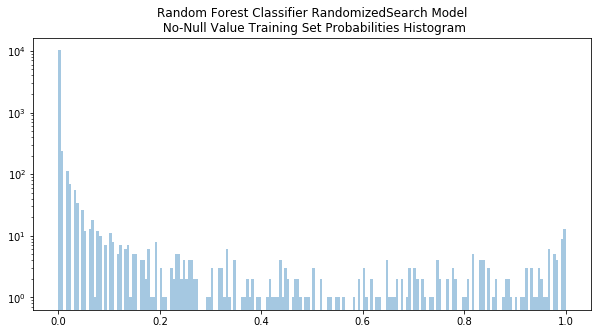

In [51]:
Plot_Probs_Histogram(y_probs, 'Random Forest Classifier RandomizedSearch Model\n No-Null Value Training Set Probabilities Histogram')

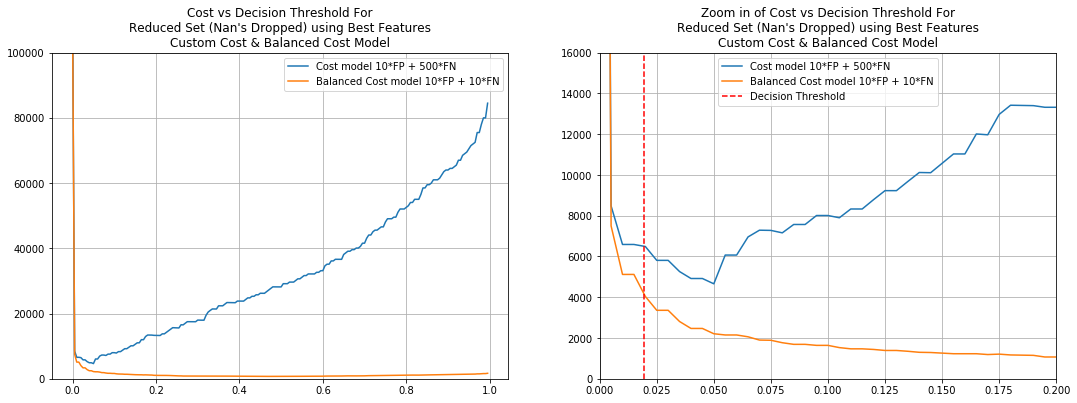

In [52]:
Plot_Cost_v_DT(y_test, y_probs, "Reduced Set (Nan's Dropped) using Best Features", 16000)

#### Now return to the full training set and fill NAN's with mode, split and scale.

In [53]:
X_Train = df_train[BestFeatures.index]
Y_Train = df_train.iloc[:,0]
X_Test = df_test[BestFeatures.index]
Y_Test = df_test.iloc[:,0]

In [54]:
# Fill NaN values with mode
Train_cols = X_Train.columns
for col in Train_cols:
    Mode = X_Train[col].mode()
    X_Train[col] = X_Train[col].fillna(Mode[0])
    X_Test[col] = X_Test[col].fillna(Mode[0])   

In [55]:
x_train, x_test, y_train, y_test = train_test_split(X_Train, Y_Train, stratify = Y_Train, test_size = 0.20, random_state = 0)

In [56]:
# Scale Train & Test
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

X_Test = scaler.transform(X_Test)

#### Fit RFC to the full dataset with filled NaN values using the hyperparameters from the second_clf Randomoized Search results.

In [57]:
third_clf = RandomForestClassifier(class_weight={0:500, 1:10},n_estimators = 130, max_depth = 20, criterion = 'entropy', random_state = 6, bootstrap = False, verbose = 0, n_jobs = -1)
third_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 500, 1: 10},
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=6, verbose=0, warm_start=False)

In [58]:
#Predict on Training test set (x_test)
y_probs = third_clf.predict_proba(x_test)
cm = confusion_matrix(y_test, y_probs[:,1]>0.0196)
print('Cost on Validation Subset of the Training set (x_test) is', 10*cm[0][1] + 500*cm[1][0],'\n')
print(cm)

Cost on Validation Subset of the Training set (x_test) is 8140 

[[11336   464]
 [    7   193]]


#### The cost is higher on the Training test set with all samples and NaN's replaced with the Feature Modes.  Now predict the Unseen Test set.  

In [59]:
#Predict main Test Set (X_Test)
Y_Probs =  third_clf.predict_proba(X_Test)
cm_X_Test = confusion_matrix(Y_Test, Y_Probs[:,1]>0.0196)
print('Cost on Unseen Test Set is', 10*cm_X_Test[0][1] + 500*cm_X_Test[1][0])

Cost on Unseen Test Set is 9060


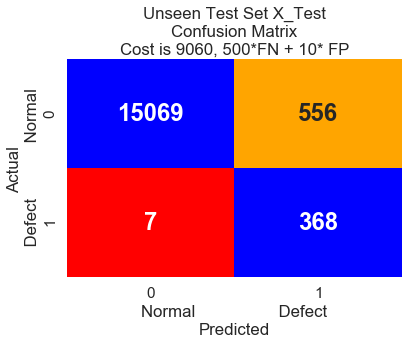

In [60]:
Plot_Conf_Matrix(cm_X_Test,'Unseen Test Set X_Test')

#### Although the Precision is only 40%, the False Negative rate is less than 2% of the total number of trucks that require an inspection and repair.  The trade off on cost with a higher number of False Positives (truck inpections that are not required) is driven by the unbalanced cost of an inspection vs. a missed inspection & repair.  The objective is to minimize cost, not maximize precision.  The cost imbalance will drive up to 50 unnecessary inspections per incremental required inspection that is missed.  The model is assigning 1.5 unnecessary inspections per required inspection recommended.  Overall inspection rate is 5.8%.  Overall required inpection rate (& service) is 2.3%.

In [61]:
print('Classification Report on the Unseen Test Set X_Test is\n')
print(classification_report(Y_Test, Y_Probs[:,1]>0.0196))

Classification Report on the Unseen Test Set X_Test is

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.40      0.98      0.57       375

    accuracy                           0.96     16000
   macro avg       0.70      0.97      0.77     16000
weighted avg       0.99      0.96      0.97     16000



#### Other possible work:  Try a neural network and a hybrid model voting from a range of classifiers.